# Predict Heart Disease based on health and behavioural indicators

This Notebook explores and models the [Personal Key Indicators of Hearth Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) dataset. My goal is to explore, analyse and visualize the data, and to build and train a Machine Learning model capable to predict if a person is prone to heart disease, or not. The main focus is to tune the model and to explain how features (i.e., health condition and habits) affect heart health.





### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score

import scikitplot as skplt

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

import shap

## I. Load Data

The dataset has 18 features: 9 booleans, 5 strings and 4 decimals.

In [3]:
indicators_data = pd.read_csv("data/heart_2020_cleaned.csv")
indicators_data.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

## II. Exploratory Data Analysis

There are 319795 samples in the dataset.

In [4]:
indicators_data.shape

(319795, 18)

The code line below prints information about each column. It could be seen that there are not missing values.

In [5]:
indicators_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

Columns with boolean values hold strings $Yes$ and $No$. Both analysis and modeling would be easier and possible with numeric values. The code line below prints out unique values in each column. Thus, I know which columns are boolean to replace them with numbers later.

In [6]:
for col in indicators_data.columns:
    print(f"Unique values in {col}:")
    print(indicators_data[col].unique())
    print("-------------------------")

Unique values in HeartDisease:
['No' 'Yes']
-------------------------
Unique values in BMI:
[16.6  20.34 26.58 ... 62.42 51.46 46.56]
-------------------------
Unique values in Smoking:
['Yes' 'No']
-------------------------
Unique values in AlcoholDrinking:
['No' 'Yes']
-------------------------
Unique values in Stroke:
['No' 'Yes']
-------------------------
Unique values in PhysicalHealth:
[ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.]
-------------------------
Unique values in MentalHealth:
[30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12.
  6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.]
-------------------------
Unique values in DiffWalking:
['No' 'Yes']
-------------------------
Unique values in Sex:
['Female' 'Male']
-------------------------
Unique values in AgeCategory:
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34'

Prior to that, however, it would be interesting to see how each indicator relates to the presence or absence of a heart disease. The function below helps to display this relation on a count plot.

In [7]:
def cross_plots(col, title = None, hue_order = None, width = 8, height = 4):
    """
    Plots relation between an indicator and a heart disease
    Arguments:
        col: (string) column against which the heart disease is explored
        title: (string) Title of the plot (optional)
        hue_order: (list) Order of colored categories to appear on plot (otional)
        width: (int) Width of plot (optional)
        height: (int) Height of plot (optional)
    """
    plt.figure(figsize = (width, height))
    sns.countplot(x = "HeartDisease", data = indicators_data,
                 hue = col, hue_order = hue_order, palette = "Spectral")
    if title is not None:
        plt.title(title, fontsize = 10)
    plt.legend(fontsize = 7)
    plt.show()

Smokers are more likely to develop heart-related problems.

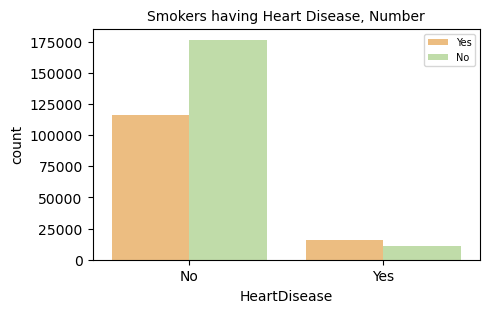

In [8]:
cross_plots("Smoking", "Smokers having Heart Disease, Number", ["Yes", "No"], 5, 3)

Most people in the sample dataset do not consume alcohol. The data suggest the latter does not affect human heart.

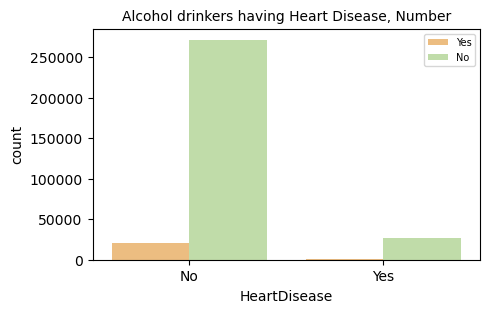

In [9]:
cross_plots("AlcoholDrinking", "Alcohol drinkers having Heart Disease, Number", ["Yes", "No"], 5, 3)

Similarly, most people didn't experience stroke. Thus, it is not associated with hearth disease.

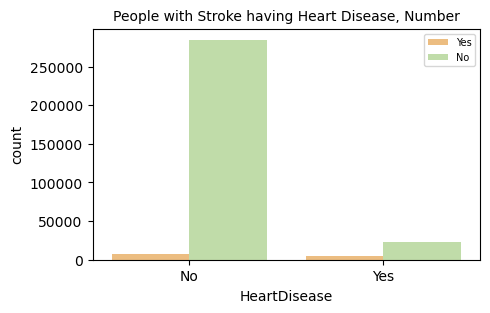

In [10]:
cross_plots("Stroke", "People with Stroke having Heart Disease, Number", ["Yes", "No"], 5, 3)

Less people who face walking difficulties also admit for heart problems.

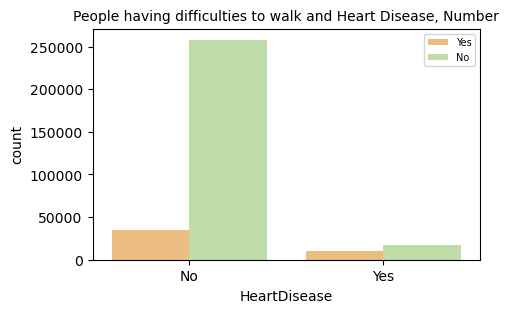

In [11]:
cross_plots("DiffWalking", "People having difficulties to walk and Heart Disease, Number", ["Yes", "No"], 5, 3)

Similarly, more people with ill hearts declare good physical activity either.

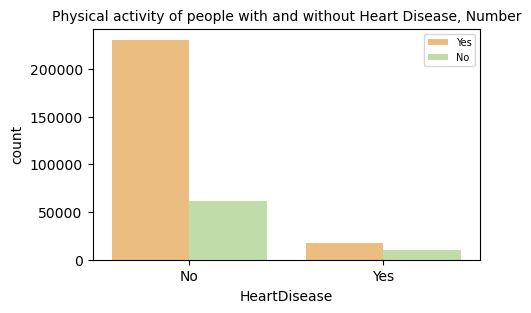

In [12]:
cross_plots("PhysicalActivity", "Physical activity of people with and without Heart Disease, Number", ["Yes", "No"], 5, 3)

Having an Asthma is not a triggering factor for heart issues.

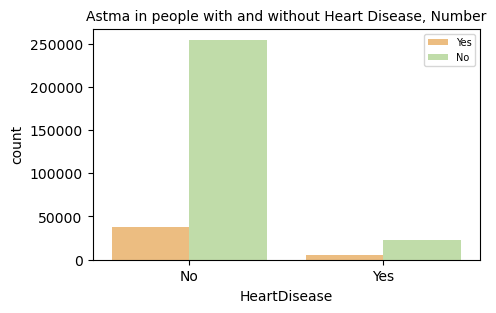

In [13]:
cross_plots("Asthma", "Astma in people with and without Heart Disease, Number", ["Yes", "No"], 5, 3)

The plot below suggest the Kidney Disease is not associated with heart problems, either.

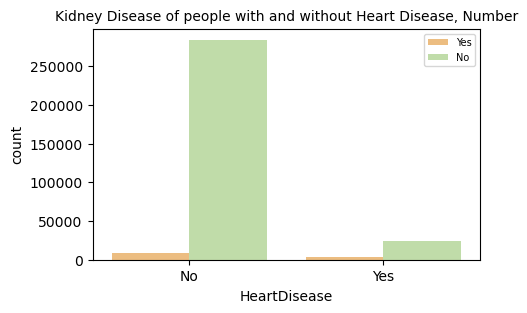

In [14]:
cross_plots("KidneyDisease", "Kidney Disease of people with and without Heart Disease, Number", ["Yes", "No"], 5, 3)

The same could be said about skin cancer.

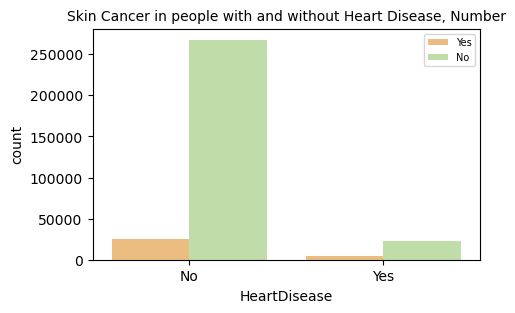

In [15]:
cross_plots("SkinCancer", "Skin Cancer in people with and without Heart Disease, Number", ["Yes", "No"], 5, 3)

The data reveal that most men than women were diagnosed with heart disease.

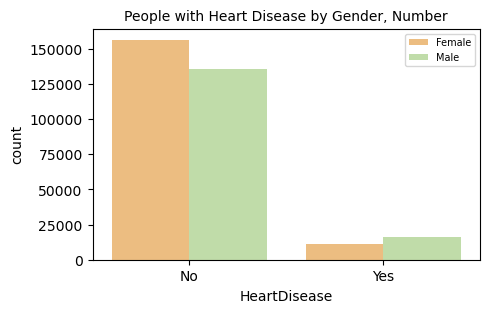

In [16]:
cross_plots("Sex", "People with Heart Disease by Gender, Number", ["Female", "Male"], 5, 3)

As could be expected, eldery people are more likely to develop heart-related problems.

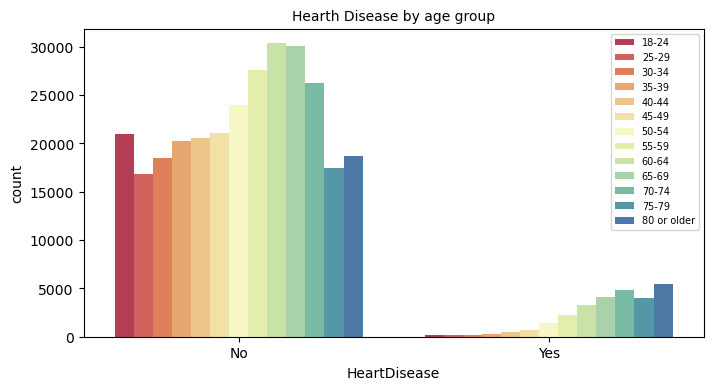

In [17]:
cross_plots("AgeCategory", "Hearth Disease by age group", ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', 
                                                           '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'], 8, 4)

The plot below suggests that white people are more likely to complain from heart problems. However, they are overrepresented in the dataset, and this could not be a valid conclusion.

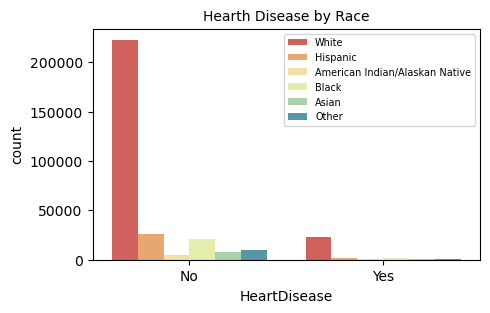

In [18]:
cross_plots("Race", "Hearth Disease by Race", ['White', 'Hispanic', 'American Indian/Alaskan Native',
                                              'Black', 'Asian', 'Other'], 5, 3)

It seems diabetes is not among predictors of a heart-disease.

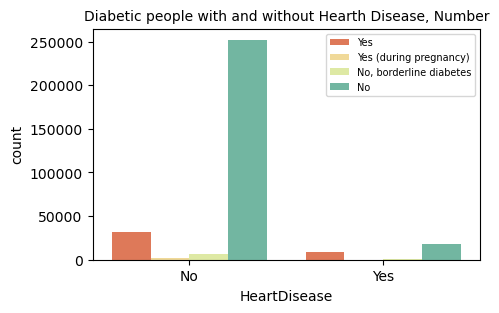

In [19]:
cross_plots("Diabetic", "Diabetic people with and without Hearth Disease, Number", 
            ['Yes', 'Yes (during pregnancy)', 'No, borderline diabetes', 'No'], 5, 3)

Similarly, neither good or excellent, nor poor  or fair general health could be a sign for heart-related issues.

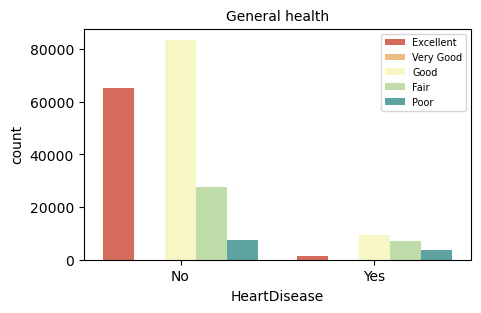

In [20]:
cross_plots("GenHealth", "General health", ["Excellent", "Very Good", "Good", "Fair", "Poor"], 5, 3)

The box plots below show the 5 number statistics of the columns with numeric values. Body Mass Index above 25 suggest that there are overweight or obese people in the dataset. Physical Health is assesed by answering to the question: "Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 [you were ill]?" Most people admitted physical health issues for less than 5 days. Similarly, with regard to Mental Health, the people were asked to respond to "Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days)". Most declared less than 5 days. The last box plot shows that people sleep between 6 and 8 hours. 

In [21]:
numeric_features = indicators_data[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']]

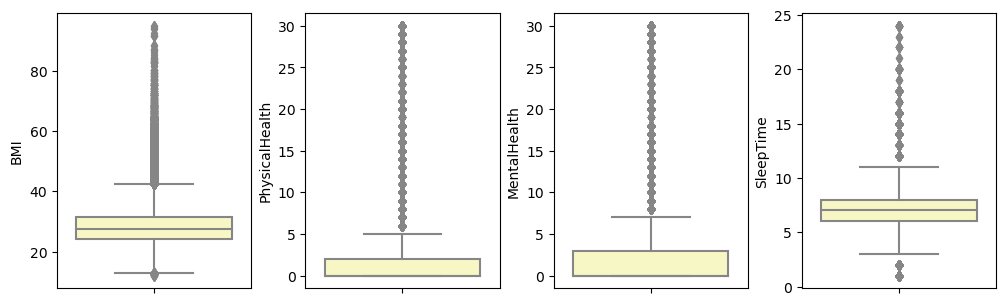

In [22]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (10, 3))
idx = 0
axs = axs.flatten()
for k, v in numeric_features.items():
    sns.boxplot(y = k, data = numeric_features, ax = axs[idx], palette = "Spectral") 
    idx += 1
plt.tight_layout(pad = 0.5, w_pad = 0.5, h_pad = 5.0)

The code line below prints out the exact figures of the 5 number statistics.

In [23]:
indicators_data.describe().T

count       mean       std    min    25%    50%    75%  \
BMI             319795.0  28.325399  6.356100  12.02  24.03  27.34  31.42   
PhysicalHealth  319795.0   3.371710  7.950850   0.00   0.00   0.00   2.00   
MentalHealth    319795.0   3.898366  7.955235   0.00   0.00   0.00   3.00   
SleepTime       319795.0   7.097075  1.436007   1.00   6.00   7.00   8.00   

                  max  
BMI             94.85  
PhysicalHealth  30.00  
MentalHealth    30.00  
SleepTime       24.00

It would be interesting to see how people with and without heart disease differ in terms of sleeping time and BMI. To visualize the differences, the data is split to people with and without heart issues.

In [24]:
hd_people = indicators_data[indicators_data["HeartDisease"] == "Yes"]
nonhd_people = indicators_data[indicators_data["HeartDisease"] == "No"]

The plot below surprisingly suggests the sleeping time does not affect heart health. Numbers of slept hours in both people categories have similar distribution, and almost identical mean. 

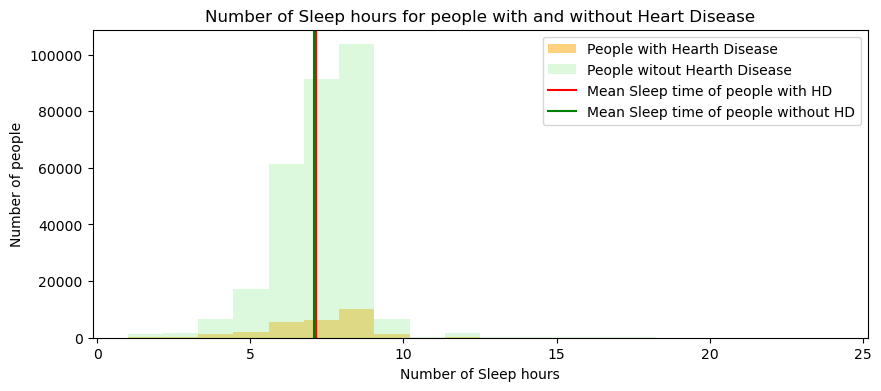

In [25]:
plt.figure(figsize = (10, 4))
plt.hist(hd_people["SleepTime"], bins = 20, color = "orange", alpha = 0.5, label = "People with Hearth Disease")
plt.hist(nonhd_people["SleepTime"], bins = 20, color = "lightgreen", alpha = 0.3, label = "People witout Hearth Disease")

mean_sleep_hd = hd_people["SleepTime"].mean()
mean_sleep_nonhd = nonhd_people["SleepTime"].mean()

plt.axvline(mean_sleep_hd, c = "r", label = "Mean Sleep time of people with HD")
plt.axvline(mean_sleep_nonhd, c = "g", label = "Mean Sleep time of people without HD")

plt.xlabel("Number of Sleep hours")
plt.ylabel("Number of people")
plt.title("Number of Sleep hours for people with and without Heart Disease")
plt.legend()
plt.show()

On the other hand, lower BMI seems to be good for heart. The mean BMI of people without heart disease is lower than the one of people with heart problems.

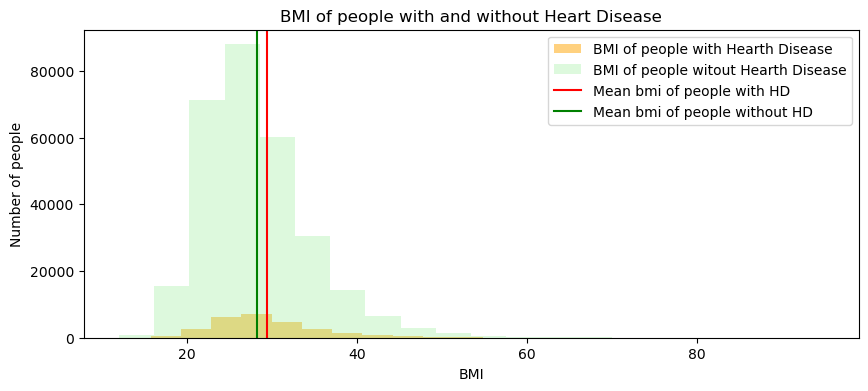

In [26]:
plt.figure(figsize = (10, 4))
plt.hist(hd_people["BMI"], bins = 20, color = "orange", alpha = 0.5, label = "BMI of people with Hearth Disease")
plt.hist(nonhd_people["BMI"], bins = 20, color = "lightgreen", alpha = 0.3, label = "BMI of people witout Hearth Disease")

mean_bmi_hd = hd_people["BMI"].mean()
mean_bmi_nonhd = nonhd_people["BMI"].mean()

plt.axvline(mean_bmi_hd, c = "r", label = "Mean bmi of people with HD")
plt.axvline(mean_bmi_nonhd, c = "g", label = "Mean bmi of people without HD")

plt.xlabel("BMI")
plt.ylabel("Number of people")
plt.title("BMI of people with and without Heart Disease")
plt.legend()
plt.show()

Neither conclusion could be claimed to be valid since the dataset is quite imbalanced - the number of people with heart disease is 10 times smaller.

In [27]:
indicators_data.groupby("HeartDisease").size()

HeartDisease
No     292422
Yes     27373
dtype: int64

## III. Data preprocessing

At this stage, the datset is being preprocessed and prepared for modelling. Values in categorical columns are converted in numeric, all figures are turned into float, features are separated from labels, feature values are normalized, and the dataset is split into train and test samples.

First, all boolean columns are converted to numeric.

In [28]:
bool_cols = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "PhysicalActivity",
            "Asthma", "KidneyDisease", "SkinCancer"]

In [29]:
def replace_booleans(col):
    """
    Replace boolean values in a column with numeric values
    Arguments: col: (string) Column with boolean values
    Returns dataset with converted boolean columns.
    """
    indicators_data[col] = indicators_data[col].map(dict(Yes = 1, No = 0))
    return indicators_data

Apply the function to replace boolean values to the whole dataframe and check if replacement was successful.

In [30]:
for col in indicators_data[bool_cols].columns:
    replace_booleans(col)

In [31]:
indicators_data

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0                  0  16.60        1                0       0             3.0   
1                  0  20.34        0                0       1             0.0   
2                  0  26.58        1                0       0            20.0   
3                  0  24.21        0                0       0             0.0   
4                  0  23.71        0                0       0            28.0   
...              ...    ...      ...              ...     ...             ...   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319793             0  32.81        0                0       0             0.0   
319794             0  46.56        0                0       0             0.0   

        MentalHealth  DiffWalking     Sex  AgeCategory      Race Diabetic  \
0               30.0            0  Female        55-59     White      Yes   
1                0.0            0  Female  80 or older     White       No   
2               30.0            0    Male        65-69     White      Yes   
3                0.0            0  Female        75-79     White       No   
4                0.0            1  Female        40-44     White       No   
...              ...          ...     ...          ...       ...      ...   
319790           0.0            1    Male        60-64  Hispanic      Yes   
319791           0.0            0    Male        35-39  Hispanic       No   
319792           0.0            0  Female        45-49  Hispanic       No   
319793           0.0            0  Female        25-29  Hispanic       No   
319794           0.0            0  Female  80 or older  Hispanic       No   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1  Very good        5.0       1              0   
1                      1  Very good        7.0       0              0   
2                      1       Fair        8.0       1              0   
3                      0       Good        6.0       0              0   
4                      1  Very good        8.0       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0       Fair        6.0       1              0   
319791                 1  Very good        5.0       1              0   
319792                 1       Good        6.0       0              0   
319793                 0       Good       12.0       0              0   
319794                 1       Good        8.0       0              0   

        SkinCancer  
0                1  
1                0  
2                0  
3                1  
4                0  
...            ...  
319790           0  
319791           0  
319792           0  
319793           0  
319794           0  

[319795 rows x 18 columns]

One-hot encoding is prefered approach to replace categorical values with numeric. Nonetheless, I use label encoder to preserve the dataset's shape, and to simplify model training and its predictions explanations. To that end, I instantiate `LabelEncoder()` and apply it to each categorical column.

In [32]:
le_sed = LabelEncoder()
indicators_data["Sex"] = le_sed.fit_transform(indicators_data["Sex"])
le_sed.classes_

array(['Female', 'Male'], dtype=object)

In [33]:
le_age = LabelEncoder()
indicators_data["AgeCategory"] = le_age.fit_transform(indicators_data["AgeCategory"])
le_age.classes_

array(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'],
      dtype=object)

In [34]:
le_race = LabelEncoder()
indicators_data["Race"] = le_race.fit_transform(indicators_data["Race"])
le_race.classes_

array(['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic',
       'Other', 'White'], dtype=object)

In [35]:
le_diab = LabelEncoder()
indicators_data["Diabetic"] = le_diab.fit_transform(indicators_data["Diabetic"])
le_diab.classes_

array(['No', 'No, borderline diabetes', 'Yes', 'Yes (during pregnancy)'],
      dtype=object)

In [36]:
le_gh = LabelEncoder()
indicators_data["GenHealth"] = le_gh.fit_transform(indicators_data["GenHealth"])
le_gh.classes_

array(['Excellent', 'Fair', 'Good', 'Poor', 'Very good'], dtype=object)

Check if encoding was successful.

In [37]:
indicators_data.head()

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0             0  16.60        1                0       0             3.0   
1             0  20.34        0                0       1             0.0   
2             0  26.58        1                0       0            20.0   
3             0  24.21        0                0       0             0.0   
4             0  23.71        0                0       0            28.0   

   MentalHealth  DiffWalking  Sex  AgeCategory  Race  Diabetic  \
0          30.0            0    0            7     5         2   
1           0.0            0    0           12     5         0   
2          30.0            0    1            9     5         2   
3           0.0            0    0           11     5         0   
4           0.0            1    0            4     5         0   

   PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  SkinCancer  
0                 1          4        5.0       1              0           1  
1                 1          4        7.0       0              0           0  
2                 1          1        8.0       1              0           0  
3                 0          2        6.0       0              0           1  
4                 1          4        8.0       0              0           0

All columns are numeric now but some hold integers and some - float values. All should be converted to floats.

In [38]:
indicators_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  int32  
 9   AgeCategory       319795 non-null  int32  
 10  Race              319795 non-null  int32  
 11  Diabetic          319795 non-null  int32  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  int32  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  int64  
 16  KidneyDisease     31

In [39]:
for col in indicators_data.columns:
    indicators_data[col] = indicators_data[col].astype("float64")

A brief check confirms all columns were successfuly converted to floats.

In [40]:
indicators_data.dtypes

HeartDisease        float64
BMI                 float64
Smoking             float64
AlcoholDrinking     float64
Stroke              float64
PhysicalHealth      float64
MentalHealth        float64
DiffWalking         float64
Sex                 float64
AgeCategory         float64
Race                float64
Diabetic            float64
PhysicalActivity    float64
GenHealth           float64
SleepTime           float64
Asthma              float64
KidneyDisease       float64
SkinCancer          float64
dtype: object

##### Balance positive and negative samples

Several algorithms (e.g., Random Forest, AdaBoost, Gradient Boosting) were tried and tested to model the data. All achieved high accuracy and f1 score (e.g., above 97%). However, precision ($\frac{TP}{TP+FP}$) and recall ($\frac{TP}{TP+FN}$) levels were more than unsatisfactory (between 0.04 and 15%). People without heart problems in the dataset are close to 300000 whereas those with ill heart - less than 30000 - 10 times less. Hence, the algorithms learned the negative class quite well but couldn't learn the positive one. I balance the dataset to address this problem by sampling equal number negative and positive samples. 

In [41]:
hd = indicators_data[indicators_data["HeartDisease"] == 1]
nonhd = indicators_data[indicators_data["HeartDisease"] == 0]

In [42]:
hd.shape, nonhd.shape

((27373, 18), (292422, 18))

In [43]:
nonhd_sample = nonhd.sample(hd.shape[0], replace=False)
nonhd_sample.shape

(27373, 18)

Both datasets are concatenated, the shape of the new dataset is checked and displayed.

In [44]:
indicators_balanced = pd.concat([hd, nonhd_sample])
indicators_balanced = indicators_balanced.sample(len(indicators_balanced))
# indicators_balanced = indicators_balanced.reset_index().drop("index", axis = 1)

print(indicators_balanced.shape)
indicators_balanced

(54746, 18)


HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
11964            1.0  25.39      1.0              0.0     0.0             0.0   
113865           1.0  32.74      1.0              0.0     0.0             3.0   
267554           1.0  35.43      0.0              0.0     0.0            25.0   
297053           0.0  20.37      0.0              1.0     0.0             0.0   
154585           1.0  34.39      1.0              0.0     0.0             8.0   
...              ...    ...      ...              ...     ...             ...   
256508           0.0  22.81      0.0              0.0     0.0             0.0   
300908           1.0  25.99      0.0              0.0     0.0             0.0   
132382           0.0  33.47      0.0              0.0     0.0             0.0   
137911           1.0  31.62      1.0              0.0     0.0             2.0   
74518            0.0  25.84      0.0              0.0     0.0             1.0   

        MentalHealth  DiffWalking  Sex  AgeCategory  Race  Diabetic  \
11964            0.0          0.0  0.0          9.0   5.0       0.0   
113865           0.0          1.0  1.0         11.0   5.0       2.0   
267554          25.0          0.0  0.0         11.0   5.0       0.0   
297053          25.0          0.0  0.0          5.0   5.0       0.0   
154585           0.0          0.0  1.0          8.0   5.0       2.0   
...              ...          ...  ...          ...   ...       ...   
256508           2.0          0.0  1.0          2.0   5.0       0.0   
300908           0.0          0.0  1.0         12.0   5.0       0.0   
132382           0.0          1.0  1.0         10.0   5.0       0.0   
137911           0.0          0.0  1.0          7.0   5.0       0.0   
74518            0.0          0.0  0.0          0.0   3.0       0.0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
11964                1.0        2.0        8.0     0.0            0.0   
113865               1.0        1.0        8.0     1.0            0.0   
267554               0.0        3.0       15.0     1.0            1.0   
297053               1.0        4.0        6.0     0.0            0.0   
154585               1.0        4.0        7.0     0.0            0.0   
...                  ...        ...        ...     ...            ...   
256508               1.0        4.0        6.0     0.0            0.0   
300908               1.0        4.0        8.0     0.0            0.0   
132382               1.0        4.0        8.0     0.0            0.0   
137911               1.0        4.0        8.0     0.0            0.0   
74518                1.0        2.0        7.0     0.0            0.0   

        SkinCancer  
11964          1.0  
113865         1.0  
267554         0.0  
297053         0.0  
154585         0.0  
...            ...  
256508         0.0  
300908         1.0  
132382         0.0  
137911         0.0  
74518          0.0  

[54746 rows x 18 columns]

Thereafter, the features (all predicting variables) and labeles are stored in separate variables.

In [45]:
# features = indicators_data.drop("HeartDisease", axis = 1)
# label = indicators_data["HeartDisease"]
features = indicators_balanced.drop("HeartDisease", axis = 1)
label = indicators_balanced["HeartDisease"]

The dataset is split into train and test samples. Both sets' shape is checked thereafter.

In [46]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.1, shuffle = True, 
                                                    stratify = label, random_state = 42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((49271, 17), (49271,), (5475, 17), (5475,))

It is important to see if data in train and test set have similar distribution with regard to the target variable.

In [47]:
def plot_splits():
    """
    Counts and plots labels in each set.   
    """ 
    plt.figure(figsize = (8, 3))
    
    plt.subplot(121)
    plt.title("In train data")
    sns.countplot(data = pd.DataFrame(y_train), x = y_train, palette = "Spectral")

    plt.subplot(122)
    plt.title("In test data")
    sns.countplot(data = pd.DataFrame(y_test), x = y_test, palette = "Spectral")

    plt.tight_layout()
    plt.show()

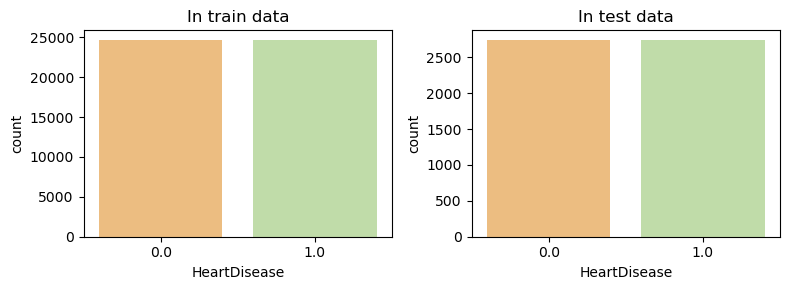

In [48]:
plot_splits()

Lastly, the feature values are normalized with `StandardScaller()`.

In [49]:
def scale_features(dataset):
    """
    Normalize numeric values
    Arguments: dataset(pd.DataFrame)
    Returns numpy.ndarray with scaled values
    """
    sc = StandardScaler()
    dataset_scaled = sc.fit_transform(dataset)
    return dataset_scaled

In [50]:
train_scaled = scale_features(x_train)
test_scaled = scale_features(x_test)

In [51]:
test_scaled[0]

array([ 0.07027086, -0.99653568, -0.23735633, -0.32395139, -0.54894775,
       -0.50190785, -0.56307688, -1.03969121,  1.27118823,  0.46612213,
       -0.55209667,  0.6255874 ,  0.57478042, -0.66218633, -0.44176226,
       -0.30106054, -0.38068155])

## IV. Build, train, and evaluate Logistic Regression

A simple $Logistic Regression$ model is tried and tested to classify the data. It should be capable to say if a person is prone to health disease based on his or her health indicators and habits.

### IV.1 Build model

Define space of hyperparameters.

In [52]:
params_lr = {
    "penalty": ['l1', 'l2'],
    "C": [1, 0.1, 0.01, 0.001, 0.0001]
}

Define $f1$ score as an evaluation metric.

In [53]:
f1 = make_scorer(f1_score, average = "weighted")

Instantiate `GridSearchCV()` to look for the best combination of hyperparameters. Cross-validate results on 5 folds.

In [54]:
gs_lr = GridSearchCV(LogisticRegression(solver = "liblinear", random_state = 42), param_grid = params_lr, scoring = f1, cv = 5)

Pass the train data to the Grid Search algorithm.

In [55]:
gs_lr.fit(train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [1, 0.1, 0.01, 0.001, 0.0001],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score, average=weighted))

The best combination of hyperparameters is shown below.

In [56]:
print(f"The best combination of hyperparameters for Logistic Regression is: {gs_lr.best_params_}")

The best combination of hyperparameters for Logistic Regression is: {'C': 1, 'penalty': 'l2'}


The average test f1 score for each combination of hyperparameters is printed below:

In [57]:
gs_lr.cv_results_['mean_test_score']

array([0.75198033, 0.75202143, 0.75191615, 0.75202124, 0.75180549,
       0.75184083, 0.74654379, 0.75093151, 0.33332206, 0.74498519])

### IV.2. Train model

The best combination of hyperparameters are defined in the `LogisticRegression()` function.

In [108]:
lr = LogisticRegression(solver="liblinear", C = 1, penalty = 'l2', random_state = 42)

The train data is passed to the instantiated algorithm.

In [109]:
lr.fit(train_scaled, y_train)

LogisticRegression(C=1, random_state=42, solver='liblinear')

### IV.3. Evaluate model

Model is evaluated by computing the difference (distance) between real and predicted values. The code line below computes predicted labels of test data.

In [110]:
predicted = lr.predict(test_scaled)

Accuracy and f1 score suggest that many samples were properly predicted. 

In [111]:
print(f"Accuracy score on test data is: {(accuracy_score(y_test, predicted) * 100):.2f}%.")
print(f"F1 score on test data is: {(f1_score(y_test, predicted) * 100):.2f}%.")

Accuracy score on test data is: 74.68%.
F1 score on test data is: 75.06%.


The classification report reveals that the modle achieves similar precision, recall and f1 score on both classes. Their levels is close to accuracy.

In [112]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      2738
         1.0       0.74      0.76      0.75      2737

    accuracy                           0.75      5475
   macro avg       0.75      0.75      0.75      5475
weighted avg       0.75      0.75      0.75      5475



## V. Build, train, and evaluate Random Forest Classifier

### V.1. Build Random Forest Classifier and grid search best hyperparameters

Let's try to build and train another model with much stronger algorithm. A slighly more convenient tool is used to select the best combination of hyperparameters - `Optuna` library. The function below defines the search space. 

In [63]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [64]:
def objective(trial, X, y, cv, scoring):
    """
    An objective function to tune hyperparameters.
    Args:
        trial: an Optuna trial
        X: DataFrame object, features
        y: Series object, Labels
        cv: k folds to cross-validate
        scoring: String, evaluation metric
    Return:
        Mean test accuracy
    """

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100, step = 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10, step = 1),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "random_state": 42,
        }
    rf = RandomForestClassifier(**params)

    scores = cross_validate(rf, X, y, cv = cv, scoring = scoring, n_jobs = -1)
    accuracy = scores["test_score"].mean()

    return accuracy

Instantiate the Optuna study (to search for hyperparameters).

In [65]:
study = optuna.create_study(direction = "maximize")

[I 2022-11-13 18:20:21,248] A new study created in memory with name: no-name-0dbeffca-a464-48b2-b49c-f6e86f8106ed


Instantiate the trial.

In [66]:
func = lambda trial: objective(trial, train_scaled, y_train, cv = kf, scoring = "accuracy")

Start optimizing with 100 trials. The cell output prints the number of each trial, the accuracy it achieved, and the combination of hyperparameters it used to achieve this value, as well as the best value so far.

In [67]:
study.optimize(func, n_trials = 100)

[I 2022-11-13 18:20:34,027] Trial 0 finished with value: 0.7401513049425725 and parameters: {'n_estimators': 60, 'max_depth': 3, 'min_samples_leaf': 10, 'max_features': 'auto'}. Best is trial 0 with value: 0.7401513049425725.
[I 2022-11-13 18:20:42,976] Trial 1 finished with value: 0.7635524481890188 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.7635524481890188.
[I 2022-11-13 18:20:45,956] Trial 2 finished with value: 0.7637351151263031 and parameters: {'n_estimators': 40, 'max_depth': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7637351151263031.
[I 2022-11-13 18:20:47,003] Trial 3 finished with value: 0.7639177491116624 and parameters: {'n_estimators': 10, 'max_depth': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7639177491116624.
[I 2022-11-13 18:20:48,435] Trial 4 finished with value: 0.7610561050803939 and parameters: {'n_e

[I 2022-11-13 18:23:11,832] Trial 35 finished with value: 0.7636538803929558 and parameters: {'n_estimators': 60, 'max_depth': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.7654602925698455.
[I 2022-11-13 18:23:18,570] Trial 36 finished with value: 0.7641816446038081 and parameters: {'n_estimators': 80, 'max_depth': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 34 with value: 0.7654602925698455.
[I 2022-11-13 18:23:21,357] Trial 37 finished with value: 0.7636539215828624 and parameters: {'n_estimators': 30, 'max_depth': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.7654602925698455.
[I 2022-11-13 18:23:26,947] Trial 38 finished with value: 0.7633088613802099 and parameters: {'n_estimators': 70, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.7654602925698455.
[I 2022-11-13 18:23:34,482] Trial 39 finished with value: 0.7645266862710025 and parameters

[I 2022-11-13 18:26:28,760] Trial 70 finished with value: 0.7337987730968539 and parameters: {'n_estimators': 70, 'max_depth': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 63 with value: 0.7660082666082594.
[I 2022-11-13 18:26:33,635] Trial 71 finished with value: 0.7657444205440014 and parameters: {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 63 with value: 0.7660082666082594.
[I 2022-11-13 18:26:38,476] Trial 72 finished with value: 0.7657444205440014 and parameters: {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 63 with value: 0.7660082666082594.
[I 2022-11-13 18:26:43,301] Trial 73 finished with value: 0.7657444205440014 and parameters: {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 63 with value: 0.7660082666082594.
[I 2022-11-13 18:26:47,307] Trial 74 finished with value: 0.7655008646276221 and paramete

In [68]:
print(f"The highest accuracy reached by this study: {((study.best_value) * 100):.4f}%.")

The highest accuracy reached by this study: 76.6008%.


The best combination of hyperparameters is:

In [69]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	n_estimators: 80
	max_depth: 10
	min_samples_leaf: 7
	max_features: log2


Store the best hyperparameters in lists.

In [70]:
n_estimators = []
max_depth = []
min_samples_leaf = []
max_features = ""

for k, v in study.best_params.items():
    if k == "n_estimators":
        n_estimators.append(v)
        n_estimators = n_estimators[0]
        
    if k == "max_depth":
        max_depth.append(v)
        max_depth = max_depth[0]
        
    if k == "min_samples_leaf":
        min_samples_leaf.append(v)
        min_samples_leaf = min_samples_leaf[0]
        
    if k == "max_features":
        max_features += v
    else:
        pass

`Optuna` provides very nice visualization tools. The first plot shows the optimization study. Blue dots indicate the reached objective value (accuracy), and the red line - the best value achieved at each iteration.

In [71]:
plot_optimization_history(study)

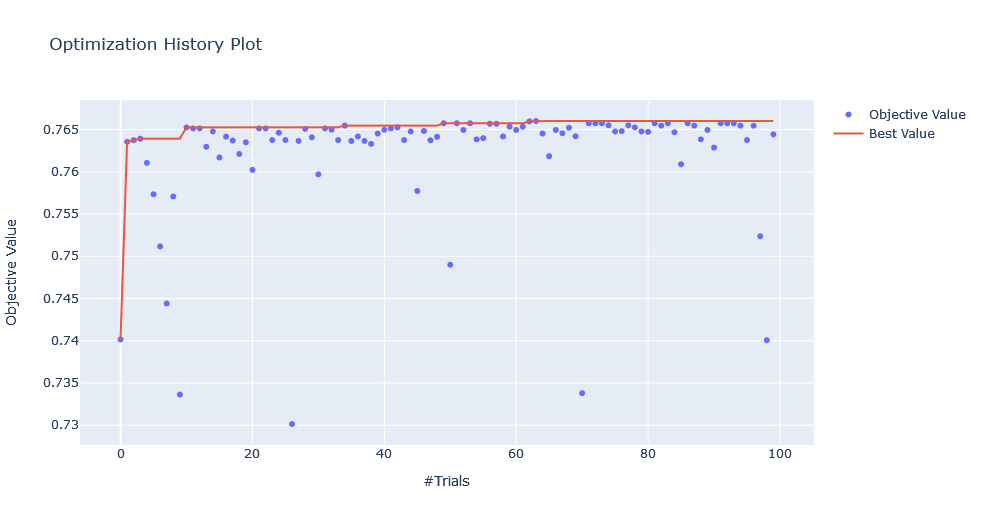

The most important hyperparameter for this model and for this training data is trees maximum depth. The others do not matter a lot.

In [72]:
plot_param_importances(study)

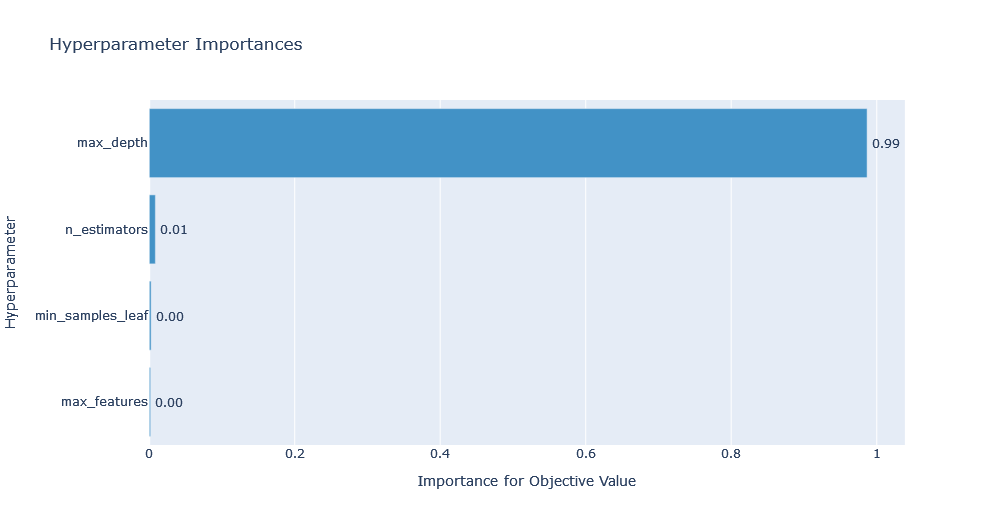

The coutour plot shows the accuracy reached in different combinations of hyperparameters with different values.

In [73]:
plot_contour(study)

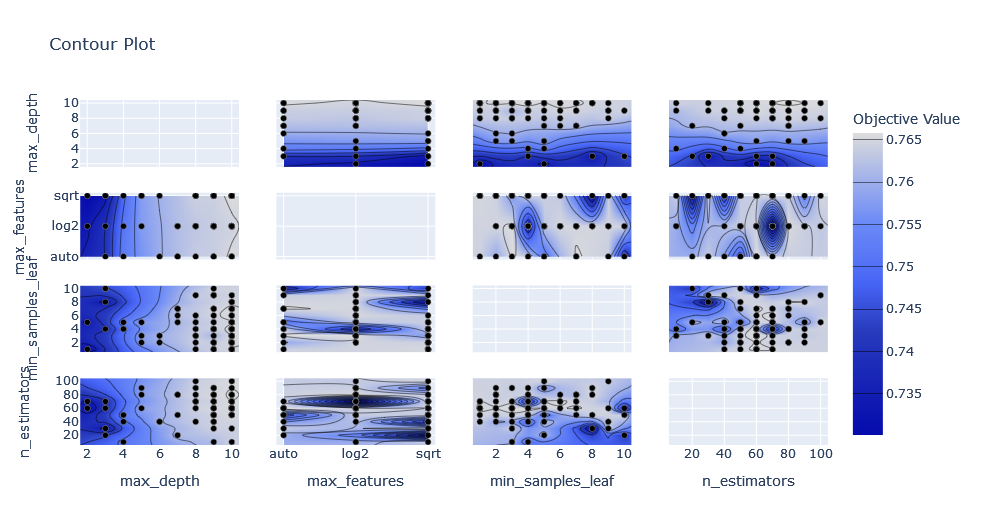

### V.2. Train Random Forest Classifier

Lastly, the best combination of hyperparameters is set into the modelling algorithm.

In [74]:
rfc = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, 
                                  max_features = max_features, min_samples_leaf=min_samples_leaf, random_state=42)

Train data is passed through the model.

In [75]:
rfc.fit(train_scaled, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=7,
                       n_estimators=80, random_state=42)

### V.3 Evaluate Random Forest model

Accuracy and f1 score reached on train and test data are not significantly higher than the ones reached by the Logistic Regression function.

In [76]:
y_pred_train = rfc.predict(train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train, average = 'weighted')

In [77]:
print(f"Accuracy on train data: {((accuracy_train)*100):.4f}%.")
print(f"F1 score on train data: {((f1_train)*100):.4f}%.")

Accuracy on train data: 77.6786%.
F1 score on train data: 77.6212%.


In [78]:
y_pred_test = rfc.predict(test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average = 'weighted')

In [79]:
print(f"Accuracy on test data: {((accuracy_test)*100):.4f}%.")
print(f"F1 score on test data: {((f1_test)*100):.4f}%.")

Accuracy on test data: 76.0365%.
F1 score on test data: 75.9817%.


However, precision and recall (sensitivity) are slightly better than it, and completely acceptable (in contrast to the values returned by all algorithms when trained on imbalanced data).

In [80]:
print(classification_report(y_test, rfc.predict(test_scaled)))

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75      2738
         1.0       0.74      0.81      0.77      2737

    accuracy                           0.76      5475
   macro avg       0.76      0.76      0.76      5475
weighted avg       0.76      0.76      0.76      5475



Most positive and negative samples were properly classified. Still, there is a significant number of samples (people), whose heart condition was wrongly predicted.

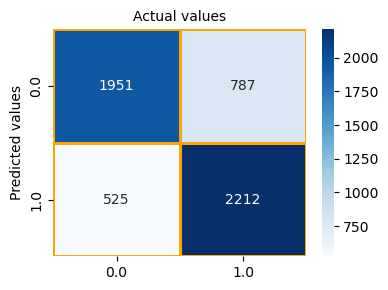

In [81]:
plt.figure(figsize = (4, 3))
sns.heatmap(confusion_matrix(y_test, rfc.predict(test_scaled)),
    annot = True, fmt = ".0f", cmap = "Blues", 
    linewidths = 2, linecolor = "orange",
    xticklabels = rfc.classes_,
    yticklabels = rfc.classes_)
plt.title("Actual values", fontsize = 10)
plt.ylabel("Predicted values",  fontsize = 10)
plt.tight_layout()
plt.show()

ROC curve and Precision and Recall Curve are evaluation metrics which illustrate model performance very well.

In [82]:
y_pred = rfc.predict_proba(test_scaled)

In [83]:
print(f"Receiver Operating Characteristic score on test data: {roc_auc_score(y_test, y_pred[:,1])}")

Receiver Operating Characteristic score on test data: 0.8322165370102054


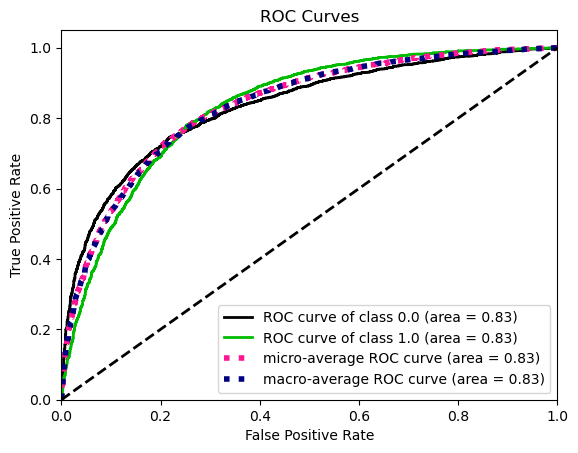

In [84]:
skplt.metrics.plot_roc(y_test, y_pred)
plt.show()

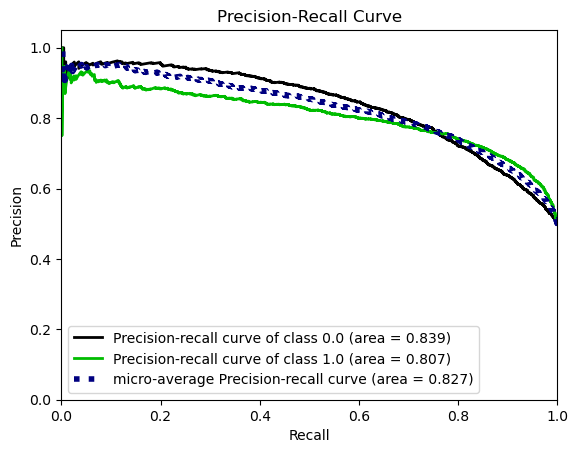

In [85]:
skplt.metrics.plot_precision_recall(y_test, rfc.predict_proba(test_scaled), title = 'Precision-Recall Curve')
plt.show()

### V.4. Interpred and explain model output

Get list of features names.

In [86]:
feat_imp_list = list(x_train.columns)

The most important features (health indicators and habits) are person's age, general health, walking difficulties,  diabetes, overall physical health, gender, and prior stroke incidents.

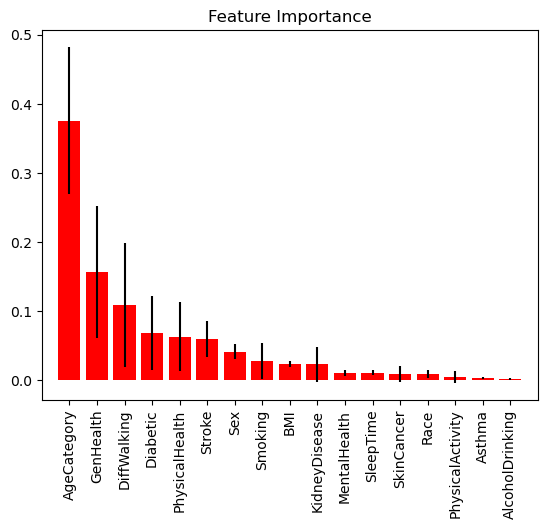

In [87]:
skplt.estimators.plot_feature_importances(rfc, feature_names = feat_imp_list, x_tick_rotation = 90)
plt.show()

The plot below shows accuracy on training and validation data on different number of samples. It seems that accuracy does not improve much with more than 30 000 samples.

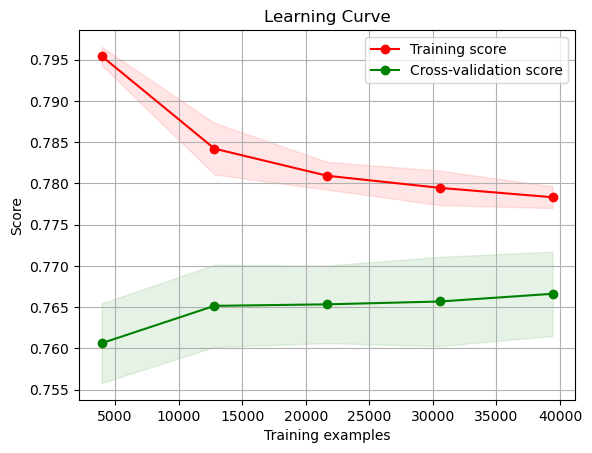

In [88]:
skplt.estimators.plot_learning_curve(rfc, x_train, y_train)
plt.show()

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. SHAP values for all train features seen and modelled by Gradient Boosting are computed below. `summary_plot` shows the impact of a feature on both classes (heart disease) and how they are stacked to create the feature importance plot. This summary plot displays what the Machine Learning algorithm managed to learn from features. All columns have equal impact (were equally important) on both classes.

In [89]:
shap_values = shap.TreeExplainer(rfc).shap_values(x_train)

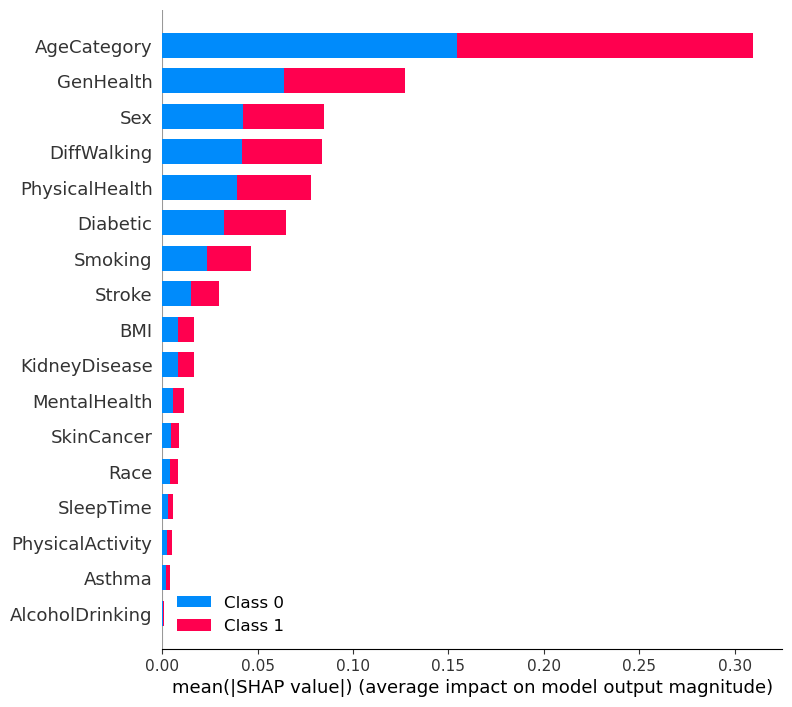

In [90]:
shap.summary_plot(shap_values, x_train)

Very useful SHAP functionality is the force plot. It provides explainability of a single model prediction: how features contributed to the model’s prediction for a specific sample, and is very convenient for error analysis or a deep understanding of a particular case.

A sample is taken out of the test data and stored in a variable (choosen_instance).

In [91]:
ind_orig = pd.read_csv("data/heart_2020_cleaned.csv")

In [101]:
x_test.sample(10)

BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  MentalHealth  \
52233   25.02      0.0              1.0     0.0             0.0           0.0   
252589  22.60      0.0              0.0     0.0             0.0           0.0   
251110  20.98      0.0              0.0     0.0             0.0           0.0   
76054   27.93      1.0              0.0     1.0             5.0           5.0   
301369  29.95      0.0              0.0     0.0             0.0           0.0   
56899   26.63      0.0              0.0     1.0            15.0          10.0   
114402  23.17      0.0              0.0     0.0             0.0           0.0   
280471  20.51      1.0              0.0     0.0             0.0           7.0   
124327  21.41      0.0              0.0     0.0             0.0           0.0   
222062  30.90      0.0              0.0     0.0             0.0           0.0   

        DiffWalking  Sex  AgeCategory  Race  Diabetic  PhysicalActivity  \
52233           0.0  1.0          7.0   5.0       0.0               1.0   
252589          0.0  0.0         12.0   5.0       2.0               1.0   
251110          0.0  0.0          5.0   5.0       0.0               1.0   
76054           1.0  0.0         10.0   5.0       0.0               0.0   
301369          0.0  0.0         11.0   5.0       0.0               1.0   
56899           0.0  1.0          8.0   2.0       0.0               1.0   
114402          0.0  0.0         11.0   5.0       0.0               1.0   
280471          0.0  0.0          0.0   5.0       0.0               1.0   
124327          0.0  1.0          1.0   5.0       0.0               1.0   
222062          0.0  0.0          5.0   5.0       0.0               1.0   

        GenHealth  SleepTime  Asthma  KidneyDisease  SkinCancer  
52233         2.0        8.0     0.0            0.0         0.0  
252589        2.0        8.0     0.0            0.0         0.0  
251110        0.0        7.0     1.0            0.0         1.0  
76054         1.0        8.0     0.0            0.0         1.0  
301369        2.0        7.0     0.0            0.0         0.0  
56899         1.0        6.0     0.0            1.0         0.0  
114402        4.0        7.0     0.0            0.0         1.0  
280471        4.0        8.0     0.0            0.0         0.0  
124327        0.0        8.0     0.0            0.0         0.0  
222062        4.0        7.0     0.0            0.0         0.0

The first sample holds information about a normal weight white man, above 75 years of age, smoker, with serious physical and mental health issues who has heart disease.

In [95]:
ind_orig.loc[[199449]]

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
199449          Yes  29.29     Yes              No     No            30.0   

        MentalHealth DiffWalking   Sex AgeCategory   Race Diabetic  \
199449          30.0         Yes  Male       75-79  White       No   

       PhysicalActivity GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
199449               No      Poor        4.0    Yes           Yes        Yes

In [96]:
choosen_instance = x_test.loc[[199449]]

In [97]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(choosen_instance)

In [98]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

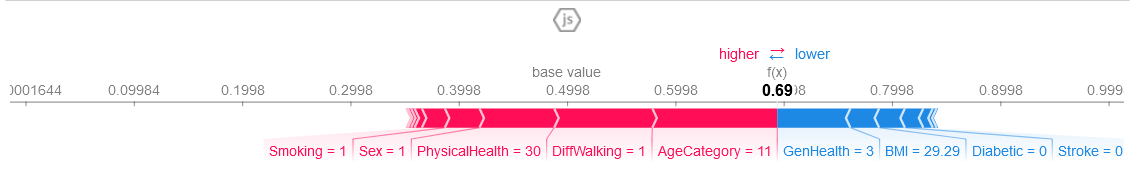

The force plot above shows that:

>The model predicted 0.69 probability of developing heart disease.

>The base value is the value that would be predicted if there was not information about any features for the current sample. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.4998.

>The numbers on the plot arrows are the value of the feature for this sample: AgeCategory = 11 and Sex = 1.

>Red represents features that push the model score higher (i.e., towards 1.00), and blue represens features that push the score lower (towards 0.00).

>The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.

Second example: white, 80+ aged normal weight female, who does not smoke and drinks alcohol with diabetes, without other serious illness but with heart disease.

In [102]:
ind_orig.loc[[252589]]

HeartDisease   BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
252589          Yes  22.6      No              No     No             0.0   

        MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
252589           0.0          No  Female  80 or older  White      Yes   

       PhysicalActivity GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
252589              Yes      Good        8.0     No            No         No

In [103]:
choosen_instance = x_test.loc[[252589]]
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

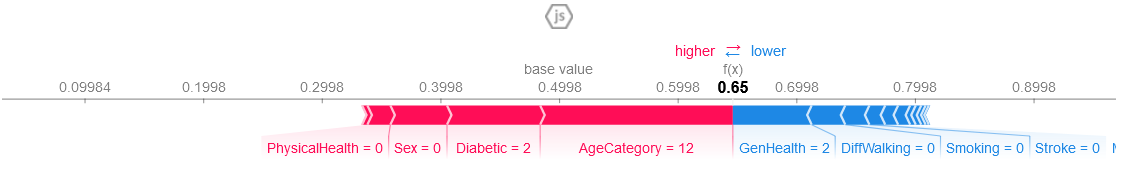

Third example: young slim white woman, who smokes, but admits mental health issues, without other illness, including heart problems.

In [107]:
ind_orig.loc[[280471]]

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
280471           No  20.51     Yes              No     No             0.0   

        MentalHealth DiffWalking     Sex AgeCategory   Race Diabetic  \
280471           7.0          No  Female       18-24  White       No   

       PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
280471              Yes  Very good        8.0     No            No         No

In [106]:
choosen_instance = x_test.loc[[280471]]
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

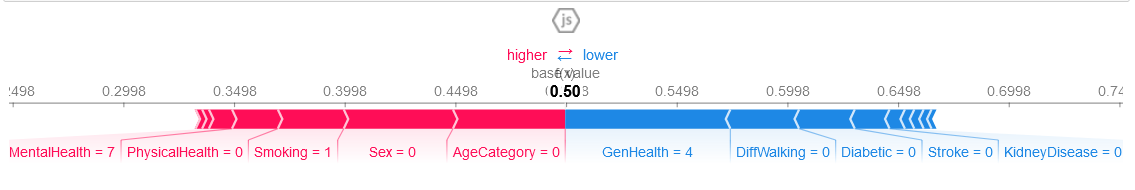